In [153]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt


_ = torch.set_grad_enabled(False)

In [154]:
model_name = "meta-llama/Llama-3.2-1B"
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Below is the function that sets the relevant weights from the Q matrix to 0.

Something to be aware of is that it modifies the weights in place, so once you run this function, the weights will be changed.

To recover the original weights, you will need to restart a session and load the model again.

In [155]:
def knock_out_attention_head(model, layer_idx, head_idx):

    # note that this function modifies the model in place and does not return anything
    # the changes you make are not recoverable, so you may want to reload the model to undo them

    layer = model.model.layers[layer_idx] # get the layer of interest
    attn = layer.self_attn # get the head of interest

    # q projection dimension is [hidden_size, hidden_size]
    hidden_size = attn.q_proj.weight.shape[0]
    num_heads = attn.num_heads  # how many heads does the layer have?
    head_dim = hidden_size // num_heads # how large is a given head?

    # Compute the slice corresponding to the head.
    start = head_idx * head_dim
    end = (head_idx + 1) * head_dim

    attn.q_proj.weight[start:end, :] = 0
    attn.v_proj.weight[start:end, :] = 0
    
    

In [156]:
model.model.layers[10].self_attn

Linear(in_features=2048, out_features=2048, bias=False)

Let's pick a head we want to knock out.

In [157]:
knockout_layer, knockout_head = 10, 23

In [158]:
total_hidden, total_head = model.config.num_hidden_layers, model.config.num_attention_heads
print("layers", total_head)
print("heads", total_hidden)

layers 32
heads 16


In [159]:
prompt = " I love lasagna. I love lasagna. I love"
model_input = tokenizer(prompt, return_tensors="pt").to(model.device)

First let's get the original attention outputs before we knock the head out.

In [160]:
original_attentions = model(**model_input, return_dict=True, output_attentions=True)["attentions"]

In [161]:
original_attentions[0].shape

torch.Size([1, 32, 13, 13])

Set the relevant weights to zero.

In [162]:
knock_out_attention_head(model, knockout_layer, knockout_head)

Now run the model again with the knocked out head.

In [163]:
knocked_out_attentions = model(**model_input, return_dict=True, output_attentions=True)["attentions"]

You can see below how the two heads are different.

The one on the left is an induction head. The one on the right is what happens when we set the Q weights to 0.

In the second matrix, all entries are not 0 but rather the entries in the same row (after the causal mask) are set to 0.

This means that attention from this head will be evenly distributed to all tokens in the sequence.

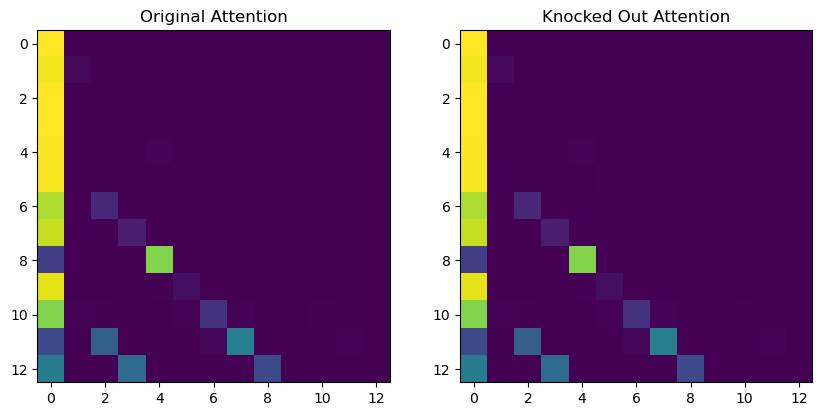

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(original_attentions[knockout_layer][0][knockout_head].to("cpu").to(float))
axs[0].set_title("Original Attention")

axs[1].imshow(knocked_out_attentions[knockout_layer][0][knockout_head].to("cpu").to(float))
axs[1].set_title("Knocked Out Attention")
plt.show()

We also make sure that the other heads from the same layer are unchanged.

In [165]:
for head in range(total_head):
    if head == knockout_head:
        continue
    original_attention = original_attentions[knockout_layer][0][head].to("cpu").to(float)
    knocked_out_attention = knocked_out_attentions[knockout_layer][0][head].to("cpu").to(float)

    assert torch.allclose(original_attention, knocked_out_attention), f"Layer {knockout_layer}, Head {head} is not equal"

In [166]:
print(tokenizer.decode(model.generate(model_input, max_length=50, do_sample=True, pad_token_id=tokenizer.eos_token_id)[0]))

AttributeError: 